## **Marketing Promotion Campaign Uplift Modelling**    
#### Customer Retention data for Churn Prediction or Uplift Modelling

**Description / Задание:**  
https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers   
1. Для нашего пайплайна поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

### Подключение библиотек и скриптов

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:72,5% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import itertools

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import ensemble
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_score, confusion_matrix, recall_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold, learning_curve

# Ensemble Methods
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

In [5]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Пути к директориям и файлам

In [7]:
# from google.colab import files
# uploaded = files.upload()

In [8]:
TRAIN_DATASET_PATH = 'churn_data.csv'

### Загрузка данных

In [9]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
# train_df.columns = map(str.lower, train_df.columns)

### Изучение датасета

In [10]:
# Количество строк и колонок в датафрейме
print(train_df.shape)

(10000, 14)


In [11]:
# Просмотр записей(строк) из начала датафрейма
train_df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00000,1,1,1,101348.88000,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86000,1,0,1,112542.58000,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80000,3,1,0,113931.57000,1
3,4,15701354,Boni,699,France,Female,39,1,0.00000,2,0,0,93826.63000,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82000,1,1,1,79084.10000,0


In [12]:
# Cведения о датафрейме
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [13]:
# Количественные переменные
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.00000,5000.50000,2886.89568,1.00000,2500.75000,5000.50000,7500.25000,10000.00000
CustomerId,10000.00000,15690940.56940,71936.18612,15565701.00000,15628528.25000,15690738.00000,15753233.75000,15815690.00000
CreditScore,10000.00000,650.52880,96.65330,350.00000,584.00000,652.00000,718.00000,850.00000
Age,10000.00000,38.92180,10.48781,18.00000,32.00000,37.00000,44.00000,92.00000
Tenure,10000.00000,5.01280,2.89217,0.00000,3.00000,5.00000,7.00000,10.00000
Balance,10000.00000,76485.88929,62397.40520,0.00000,0.00000,97198.54000,127644.24000,250898.09000
NumOfProducts,10000.00000,1.53020,0.58165,1.00000,1.00000,1.00000,2.00000,4.00000
HasCrCard,10000.00000,0.70550,0.45584,0.00000,0.00000,1.00000,1.00000,1.00000
IsActiveMember,10000.00000,0.51510,0.49980,0.00000,0.00000,1.00000,1.00000,1.00000
EstimatedSalary,10000.00000,100090.23988,57510.49282,11.58000,51002.11000,100193.91500,149388.24750,199992.48000


In [14]:
# Категориальные переменные
train_df.describe(include=['O']).T

,count,unique,top,freq
Surname,10000,2932,Smith,32
Geography,10000,3,France,5014
Gender,10000,2,Male,5457


In [15]:
# Категориальные переменные
train_df.describe(include=np.object)

,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


In [16]:
# Пропуски в данных
train_df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [17]:
# Целевая переменная
train_df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

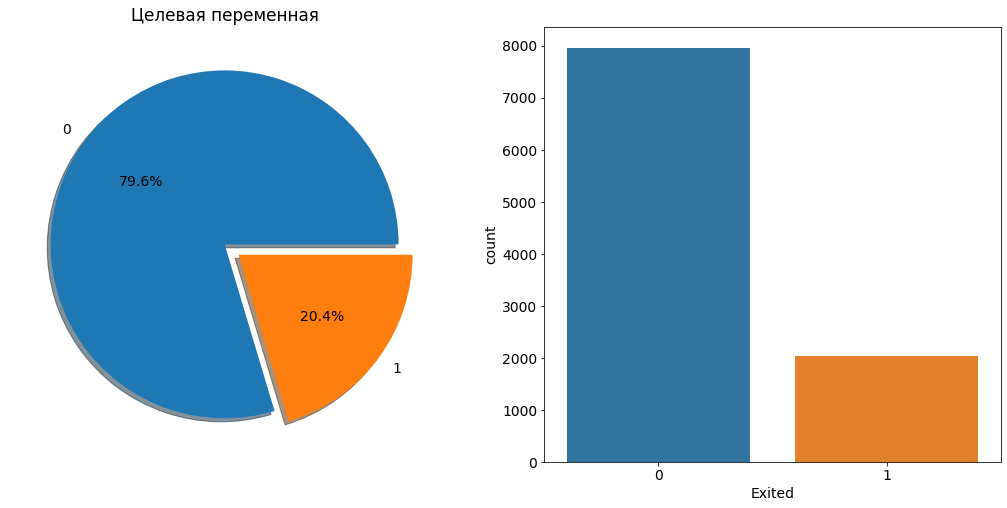

In [18]:
f, ax=plt.subplots(1, 2, figsize=(18, 8))
train_df['Exited'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Целевая переменная')
ax[0].set_ylabel('')
sns.countplot('Exited', data=train_df, ax=ax[1])
# ax[1].set_title('Exited')
plt.show()

### Корреляция признаков

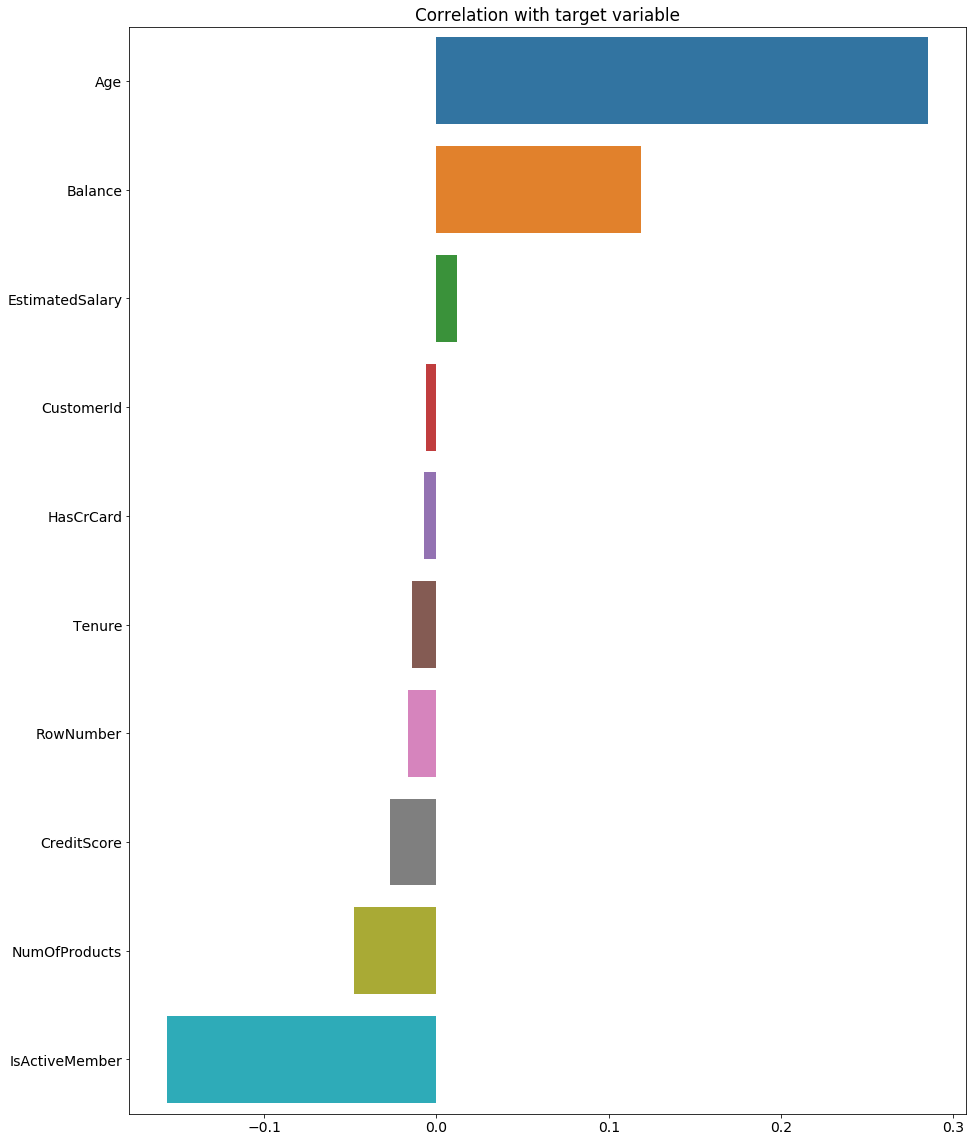

In [19]:
TARGET_NAME = 'Exited'

corr_with_target = train_df.corr()[TARGET_NAME].sort_values(ascending=False)[1:]
plt.figure(figsize=(15, 20))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

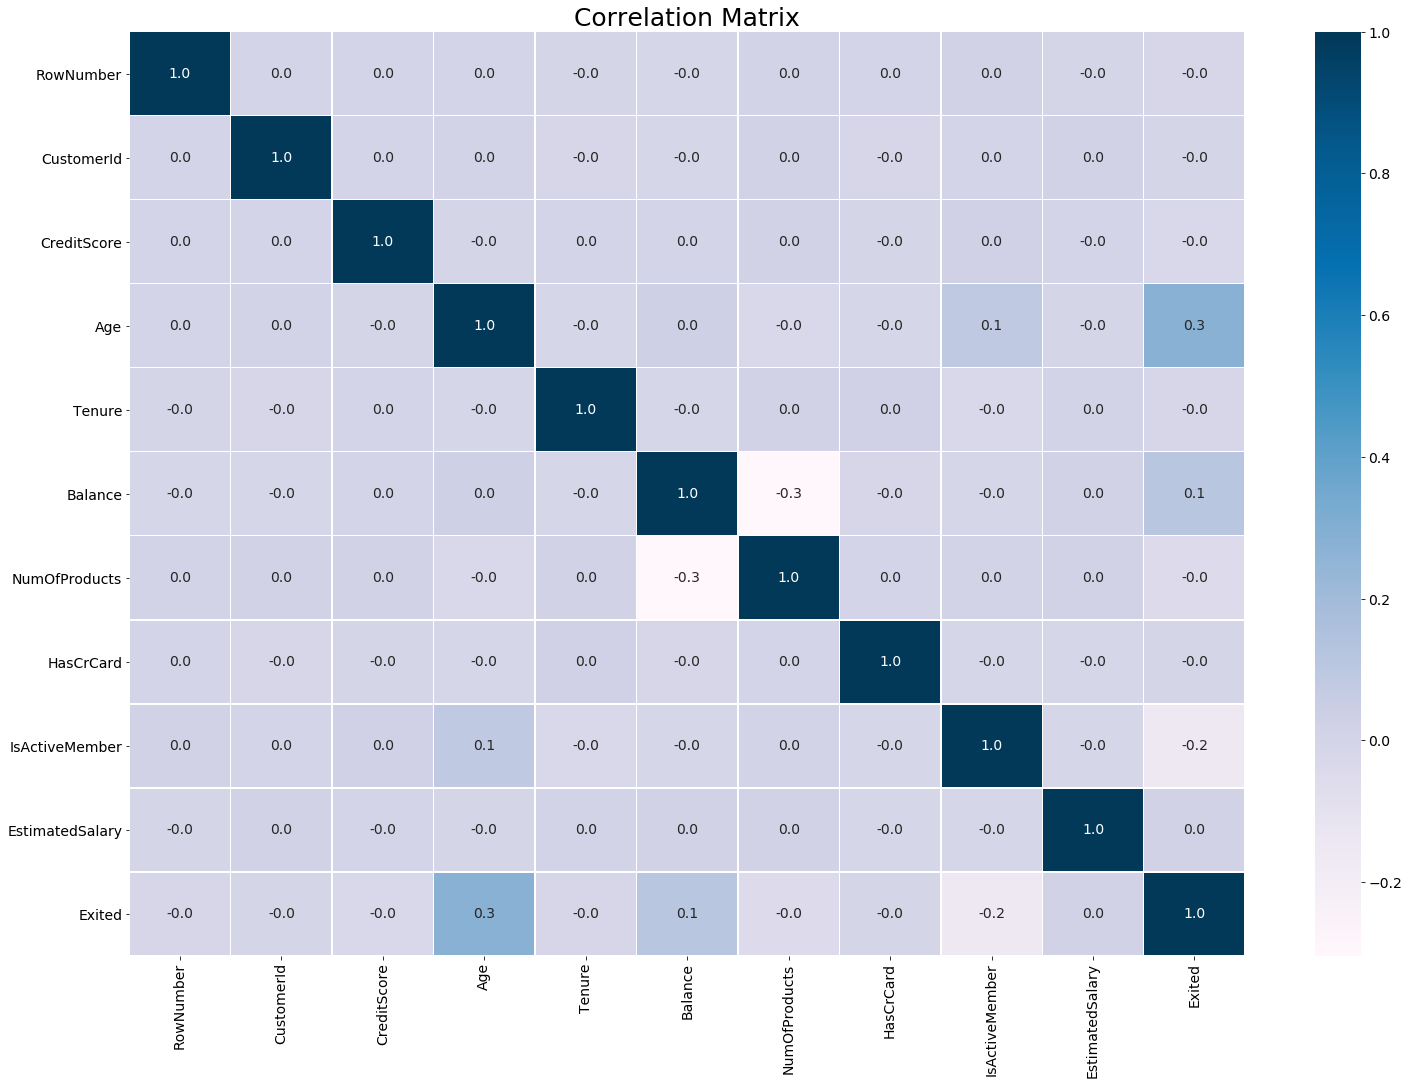

In [20]:
# Correlation Matrix
f, ax = plt.subplots(figsize = [25, 17])
sns.heatmap(train_df.corr(), annot=True, fmt='.1f', linewidths=.5, ax=ax, cmap = 'PuBu' )
ax.set_title('Correlation Matrix', fontsize=25)
plt.show()

In [21]:
train_df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [22]:
train_df['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

In [23]:
train_df = pd.get_dummies(train_df, columns = ['Geography', 'Gender'], drop_first = False)

In [24]:
# # Преобразование в фиктивную переменную:
# train_df['Gender_Female'] = (train_df['Gender'] == 'Female').astype('bool')
# train_df['Gender_Male'] = (train_df['Gender'] == 'Male').astype('bool')
# train_df.drop(['Gender'], axis=1, inplace=True)

# # Преобразование в фиктивную переменную:
# train_df['Geography_France'] = (train_df['Geography'] == 'France').astype('bool')
# train_df['Geography_Germany'] = (train_df['Geography'] == 'Germany').astype('bool')
# train_df['Geography_Spain'] = (train_df['Geography'] == 'Spain').astype('bool')
# train_df.drop(['Geography'], axis=1, inplace=True)

train_df = train_df.drop(['CustomerId', 'Surname', 'RowNumber', 'Geography_Spain', 'Geography_France'], axis = 1)

In [25]:
train_df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Gender_Female,Gender_Male
0,619,42,2,0.00000,1,1,1,101348.88000,1,0,1,0
1,608,41,1,83807.86000,1,0,1,112542.58000,0,0,1,0
2,502,42,8,159660.80000,3,1,0,113931.57000,1,0,1,0
3,699,39,1,0.00000,2,0,0,93826.63000,0,0,1,0
4,850,43,2,125510.82000,1,1,1,79084.10000,0,0,1,0


In [26]:
# Cведения о датафрейме
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  int64  
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  uint8  
 10  Gender_Female      10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(2), int64(7), uint8(3)
memory usage: 732.5 KB


### Подготовка признаков

In [27]:
X = pd.get_dummies(train_df)
X.drop('Exited', axis=1, inplace=True)
y = train_df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y)

### Первичный подбор стандартных моделей:

In [28]:
models = []

models.append(('CatBoostClassifier', CatBoostClassifier(silent=True)))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier()))
models.append(('LGBMClassifier', LGBMClassifier()))
models.append(('LogisticRegression', LogisticRegression()))
models.append(('RandomForestClassifier', RandomForestClassifier()))

In [29]:
results = []

for name, model in models:
    model.fit(X_train, y_train)
    y_pred_train  = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    TRAIN = f1_score(y_train, y_pred_train)
    Accuracy_scores = accuracy_score(y_test, y_pred_test)
    TEST = f1_score(y_test, y_pred_test)
    results.append((name, TRAIN, TEST, Accuracy_scores))
    
best_models = pd.DataFrame(results, columns = ['model', 'TRAIN - f1_score', 'TEST - f1_score', 'Accuracy_scores'])
best_models.sort_values('TEST - f1_score', ascending=False)

,model,TRAIN - f1_score,TEST - f1_score,Accuracy_scores
0,CatBoostClassifier,0.73165,0.61775,0.87080
2,LGBMClassifier,0.75815,0.61124,0.86720
1,GradientBoostingClassifier,0.61909,0.60072,0.86600
4,RandomForestClassifier,1.00000,0.58111,0.86160
3,LogisticRegression,0.11380,0.09898,0.78880


**Балансировка по целевому классу**

In [30]:
def balance_df_by_target(train_df, y, portion_of_target_class=0.5, random_state=15):
    counts_0 = (train_df[TARGET_NAME] == 0).sum()
    counts_1 = (train_df[TARGET_NAME] == 1).sum()
    minor_class = 0 if (counts_0 < counts_1) else 1
    if portion_of_target_class > (counts_1 / (counts_1 + counts_0)):
        disbalance = int(counts_0 / (1-portion_of_target_class) - counts_1 - counts_0)
    else:
        disbalance = int(counts_1 / (1-portion_of_target_class) - counts_1 - counts_0)
    sample = train_df[train_df[y] == minor_class].sample(n=disbalance, replace=True, random_state=random_state)

    return pd.concat([sample, train_df], axis=0)

In [31]:
df_balanced = balance_df_by_target(pd.concat([X_train, y_train], axis=1), TARGET_NAME, 0.50, 2)
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

In [32]:
results = []

for name, model in models:
    model.fit(X_train, y_train)
    y_pred_train  = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    TRAIN = f1_score(y_train, y_pred_train)
    Accuracy_scores = accuracy_score(y_test, y_pred_test)
    TEST = f1_score(y_test, y_pred_test)
    results.append((name, TRAIN, TEST, Accuracy_scores))
    
best_models = pd.DataFrame(results, columns = ['model', 'TRAIN - f1_score', 'TEST - f1_score', 'Accuracy_scores'])
best_models.sort_values('TEST - f1_score', ascending=False)

,model,TRAIN - f1_score,TEST - f1_score,Accuracy_scores
4,RandomForestClassifier,1.00000,0.60946,0.85800
1,GradientBoostingClassifier,0.80600,0.60778,0.80640
0,CatBoostClassifier,0.91586,0.60531,0.82160
2,LGBMClassifier,0.90987,0.60465,0.81640
3,LogisticRegression,0.66744,0.43590,0.64800


### Алгоритм - CatBoostClassifier

In [33]:
%%time
model_cbc = CatBoostClassifier(silent=True)
model_cbc.fit(X_train, y_train)
y_pred_train  = model_cbc.predict(X_train)
y_pred_test = model_cbc.predict(X_test)
print('TRAIN - CatBoostClassifier\n\n' + classification_report(y_train, y_pred_train))
print('TEST - CatBoostClassifier\n\n' + classification_report(y_test, y_pred_test))
print(f'TRAIN - CatBoostClassifier - {f1_score(y_train, y_pred_train)}')
print(f'TEST - CatBoostClassifier - {f1_score(y_test, y_pred_test)}')

TRAIN - CatBoostClassifier

              precision    recall  f1-score   support

           0       0.92      0.91      0.91      5968
           1       0.91      0.92      0.92      5968

    accuracy                           0.92     11936
   macro avg       0.92      0.92      0.92     11936
weighted avg       0.92      0.92      0.92     11936

TEST - CatBoostClassifier

              precision    recall  f1-score   support

           0       0.91      0.86      0.88      1995
           1       0.55      0.68      0.61       505

    accuracy                           0.82      2500
   macro avg       0.73      0.77      0.75      2500
weighted avg       0.84      0.82      0.83      2500

TRAIN - CatBoostClassifier - 0.9158551810237202
TEST - CatBoostClassifier - 0.6053097345132743
Wall time: 8.96 s


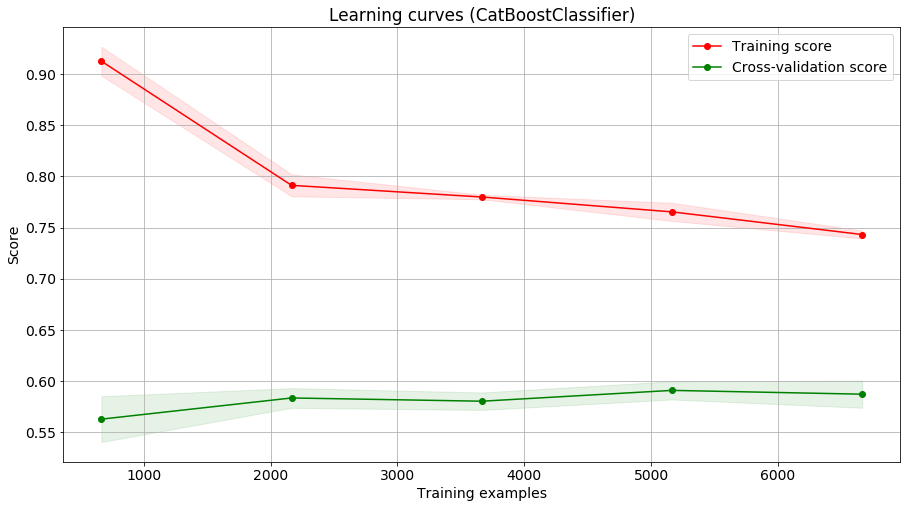

In [34]:
show_learning_curve_plot(model_cbc, X, y)

Confusion matrix, without normalization
[[1712  283]
 [ 163  342]]


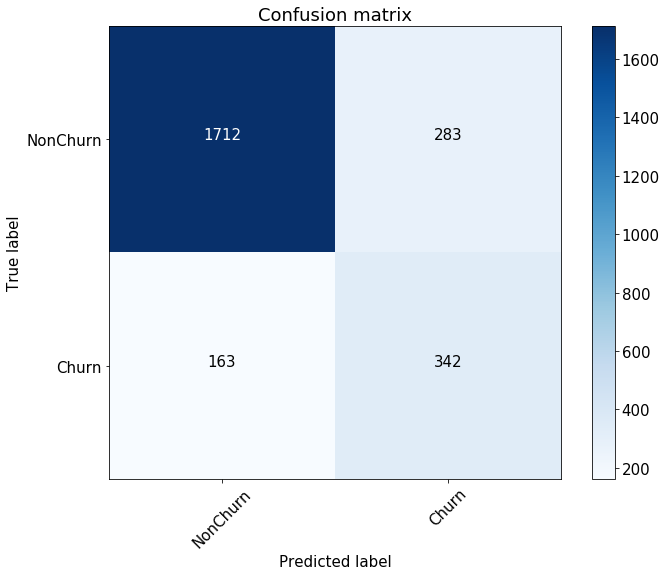

In [35]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [36]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

In [37]:
efficiency = (TP * 2) - (TP + FN) * 1
efficiency

179

In [38]:
%%time
model_cbc = CatBoostClassifier(learning_rate=0.02, max_depth=6, silent=True, random_state=4)
model_cbc.fit(X_train, y_train)
y_pred_train  = model_cbc.predict(X_train)
y_pred_test = model_cbc.predict(X_test)
print('TEST - CatBoostClassifier\n\n' + classification_report(y_test, y_pred_test))
print(f'TRAIN - CatBoostClassifier - {f1_score(y_train, y_pred_train)}')
print(f'TEST - CatBoostClassifier - {f1_score(y_test, y_pred_test)}')

TEST - CatBoostClassifier

              precision    recall  f1-score   support

           0       0.92      0.85      0.88      1995
           1       0.54      0.70      0.61       505

    accuracy                           0.82      2500
   macro avg       0.73      0.77      0.74      2500
weighted avg       0.84      0.82      0.83      2500

TRAIN - CatBoostClassifier - 0.8846443830108067
TEST - CatBoostClassifier - 0.6072664359861591
Wall time: 9.5 s


In [39]:
# estimator = CatBoostClassifier(silent=True)
# param_grid = {
#     'n_estimators': [850],
#     'max_depth': [6],
#     'random_state': [4]
# }

# model_cbc = GridSearchCV(estimator, param_grid, scoring='f1')
# model_cbc.fit(X_train, y_train)

# print('Best parameters found by grid search are:', model_cbc.best_params_)

Confusion matrix, without normalization
[[1695  300]
 [ 154  351]]


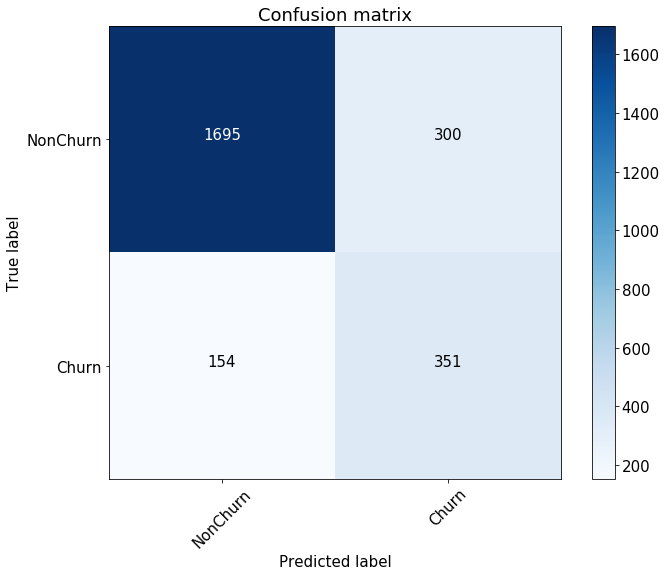

In [40]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [41]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

In [42]:
efficiency = (TP * 2) - (TP + FN) * 1
efficiency

197